# Predição da Qualidade do Vinho

## Análise de Dados e Modelagem com PyTorch e Scikit-Learn

Arthur Cardoso 211038191
Artur Padovesi 211038208

In [26]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset


In [27]:
data = pd.read_csv('winequalityN.csv')
data

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


## Início do Tratamento dos Dados

Antes de prosseguir com a modelagem, é necessário realizar o tratamento dos dados para garantir que estejam prontos para análise. Na célula abaixo, realizamos a codificação da variável categórica `type` utilizando `LabelEncoder`, transformando-a em valores numéricos. Além disso, verificamos a existência de valores nulos no conjunto de dados e removemos as linhas que possuem valores faltantes, garantindo a integridade dos dados para as próximas etapas.


In [28]:
# Encoding type of wine
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])

print(data.isnull().sum())

# remover linhas que possuem valores faltantes
data.dropna(inplace=True)

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


Antes mesmo da criação e treinamento do modelo, podemos fazer uma análise de informação mútua entre os parâmetros e a classificação

In [29]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

x, y = data.drop(columns=['quality']), data['quality']

mi = mutual_info_regression(x, y, random_state=0)
# mi = mutual_info_classif(x, y, random_state=0)
mi_df = pd.Series(mi, index=x.columns).sort_values(ascending=False)
mi_df

alcohol                 0.160126
density                 0.149433
total sulfur dioxide    0.067258
chlorides               0.066973
residual sugar          0.053237
citric acid             0.051566
volatile acidity        0.043367
free sulfur dioxide     0.040078
sulphates               0.011959
fixed acidity           0.007244
pH                      0.005783
type                    0.005761
dtype: float64

## Separação e Normalização dos Dados

Dividimos o conjunto de dados em três partes: treinamento, validação e teste, utilizando a função `train_test_split` do `sklearn.model_selection`. Após a separação, normalizamos as features (exceto a coluna `quality`) utilizando o `MinMaxScaler` do `sklearn.preprocessing`, garantindo que os valores estejam entre 0 e 1. Essa etapa é essencial para melhorar a performance do modelo durante o treinamento.


In [30]:
# Split the into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

x_train, y_train = train_data.drop(columns=['quality']), train_data['quality']
x_val, y_val = val_data.drop(columns=['quality']), val_data['quality']
x_test, y_test = test_data.drop(columns=['quality']), test_data['quality']


# Normalizar as features (exceto a coluna 'quality')
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_val = pd.DataFrame(scaler.transform(x_val), columns=x_val.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)


# Convert to PyTorch tensors
X_train, Y_train = torch.tensor(x_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
train_ds = TensorDataset(X_train, Y_train)

X_val, Y_val = torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)
val_ds = TensorDataset(X_val, Y_val)

X_test, Y_test = torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

n_features = X_val.shape[1]
n_features

12

## Treinamento do Modelo com a Classe `LinearRegression`

Nesta etapa, treinamos um modelo de regressão linear simples utilizando a classe `LinearRegression`. O modelo possui uma camada linear com pesos e bias inicializados aleatoriamente. O treinamento é realizado com o otimizador SGD e a função de perda L1, ajustando os pesos para minimizar o erro entre as predições e os valores reais. As perdas de treinamento e validação são registradas para análise.


In [31]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=n_features, out_features=1)  # 'n_features' entradas, 1 saída
        nn.init.normal_(self.linear.weight, mean=0, std=0.01)
        nn.init.zeros_(self.linear.bias)

    def forward(self, X):
        return self.linear(X)

def get_loss_fn():
    return nn.L1Loss()
    # return nn.MSELoss()

def get_optimizer(model, lr):
    return optim.SGD(model.parameters(), lr=lr)

In [32]:
model = LinearRegression()
loss_fn = get_loss_fn()
optimizer = get_optimizer(model, lr=1e-3)

num_epochs = 100

val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_val), Y_val)
        train_loss = loss_fn(model(X_train), Y_train)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
        # val_loss = sum(loss_fn(model(X_val), torch.tensor(y_val))) / len(y_val)
    # print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

C:\Users\tucol\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\tucol\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
C:\Users\tucol\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([1034])) that is different to the input size (torch.Size([1034, 1])). This will likely lead to incorrect results due to broadcasting.

C:\Users\tucol\AppData\Local\Temp\ipykernel_1704\988218536.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


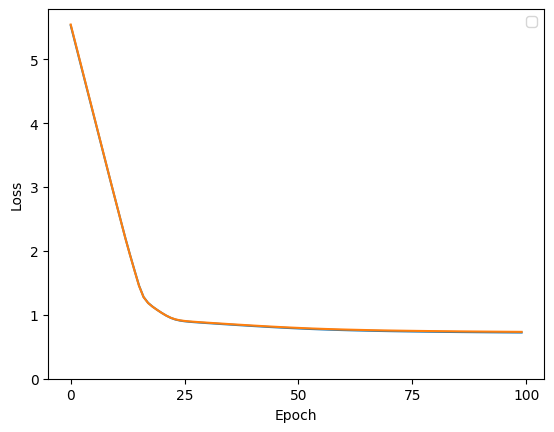

In [33]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, num_epochs, 5))
# plt.xticks(np.arange(0, num_epochs))
plt.legend()
plt.plot(val_losses, label="Validation Loss")
plt.plot(train_losses, label="Training Loss")
# plt.xlim(0, 10)
plt.ylim(bottom=0)
plt.show()

## Análise de Correlação entre as Colunas

Nesta etapa, iremos explorar a correlação entre as diferentes colunas do conjunto de dados. A análise de correlação é uma ferramenta importante para identificar relações lineares entre variáveis, o que pode ajudar a entender quais atributos têm maior influência na variável alvo (`quality`). Essa análise também pode ser útil para identificar colunas redundantes ou altamente correlacionadas, que podem ser removidas ou tratadas para evitar multicolinearidade nos modelos.

In [44]:
inp_names = list(data.columns)[0:-1]
inp_w_values = model.linear.weight.detach().numpy().reshape((len(inp_names),))
for i in range(len(inp_names)):
  print(f"{inp_names[i]:20}: {inp_w_values[i]:.2f}")

type                : 1.01
fixed acidity       : 1.00
volatile acidity    : 0.87
citric acid         : 0.55
residual sugar      : 0.18
chlorides           : 0.38
free sulfur dioxide : 0.22
total sulfur dioxide: 0.48
density             : 0.57
pH                  : 1.25
sulphates           : 0.65
alcohol             : 0.87


In [35]:
from scipy.stats import kendalltau

y_pred = model(X_test)
loss = loss_fn(y_pred, Y_test)

# kendalltau é uma medida de correlação que compara a ordem relativa de cada par de pontos, desconsiderando a magnitude
# ou seja, quanto melhor nossa predição manter a ordem dos ranques, maior o valor de tau
tau, _ = kendalltau(y_test, y_pred.detach().numpy())
print(f"Kendall's Tau: {tau:.2f}")
print(f"Loss: {loss:.2f}")


Kendall's Tau: 0.18
Loss: 0.75


C:\Users\tucol\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([1293])) that is different to the input size (torch.Size([1293, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [36]:
columns_to_drop = [
    # total sulfur dioxide possui correlação grande com 'type' e com 'free sulfur dioxide'
    # podemos então testar criar o modelo sem essa informação
    "total sulfur dioxide"
]

x_test = x_test

# Convert to PyTorch tensors
X_train, Y_train = torch.tensor(x_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)
train_ds = TensorDataset(X_train, Y_train)

X_val, Y_val = torch.tensor(x_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)
val_ds = TensorDataset(X_val, Y_val)

X_test, Y_test = torch.tensor(x_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

n_features = X_val.shape[1]
n_features

12

## Re-treinamento do Modelo

Nesta etapa, realizaremos o re-treinamento do modelo utilizando os dados ajustados. O objetivo é verificar se a remoção de colunas altamente correlacionadas ou redundantes, como `total sulfur dioxide`, pode melhorar o desempenho do modelo. O processo de treinamento será semelhante ao anterior, com a mesma arquitetura de modelo, função de perda e otimizador, mas agora utilizando o conjunto de dados modificado.

In [37]:
model = LinearRegression()
loss_fn = get_loss_fn()
optimizer = get_optimizer(model, lr=1e-3)

num_epochs = 100

val_losses = []
train_losses = []

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        preds = model(X_batch)
        loss = loss_fn(preds, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(model(X_val), Y_val)
        train_loss = loss_fn(model(X_train), Y_train)
    val_losses.append(val_loss)
    train_losses.append(train_loss)
        # val_loss = sum(loss_fn(model(X_val), torch.tensor(y_val))) / len(y_val)
    # print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

C:\Users\tucol\AppData\Local\Temp\ipykernel_1704\988218536.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


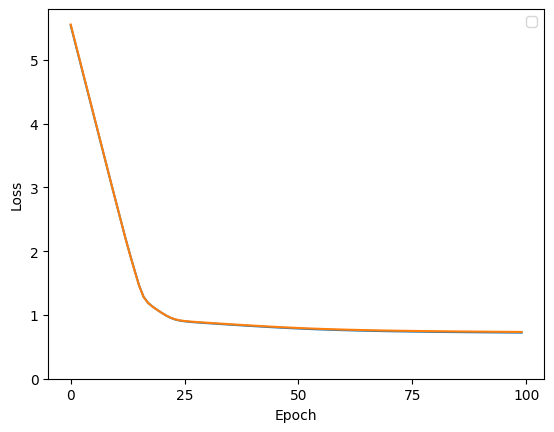

In [38]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, num_epochs, 5))
# plt.xticks(np.arange(0, num_epochs))
plt.legend()
plt.plot(val_losses, label="Validation Loss")
plt.plot(train_losses, label="Training Loss")
# plt.xlim(0, 10)
plt.ylim(bottom=0)
plt.show()

In [39]:
from scipy.stats import kendalltau

y_pred = model(X_test)
loss = loss_fn(y_pred, Y_test)

# kendalltau é uma medida de correlação que compara a ordem relativa de cada par de pontos, desconsiderando a magnitude
# ou seja, quanto melhor nossa predição manter a ordem dos ranques, maior o valor de tau
tau, _ = kendalltau(y_test, y_pred.detach().numpy())
print(f"Kendall's Tau: {tau:.2f}")
print(f"Loss: {loss:.2f}")


Kendall's Tau: 0.19
Loss: 0.75


In [40]:
## Calcular o erro médio absoluto (MAE) 
from sklearn.metrics import mean_absolute_error

# Calcular o erro médio absoluto
mae = mean_absolute_error(Y_test.numpy(), y_pred.detach().numpy())
print(f"Erro Médio Absoluto (MAE): {mae:.2f}")

Erro Médio Absoluto (MAE): 0.68


In [41]:
# Preditor trivial: atribuir o valor médio de 'quality' como predição
mean_quality = y_train.mean()
trivial_preds = torch.full_like(Y_test, mean_quality, dtype=torch.float32)

# Calcular o erro médio absoluto (MAE) do preditor trivial
trivial_mae = mean_absolute_error(Y_test.numpy(), trivial_preds.numpy())

# Exibir os resultados
print(f"Erro Médio Absoluto (MAE) do modelo: {mae:.2f}")
print(f"Erro Médio Absoluto (MAE) do preditor trivial: {trivial_mae:.2f}")

Erro Médio Absoluto (MAE) do modelo: 0.68
Erro Médio Absoluto (MAE) do preditor trivial: 0.71


In [42]:
# Calcular a acurácia do modelo
y_pred_classes = torch.round(y_pred).squeeze()  # Arredondar as predições para o inteiro mais próximo
model_accuracy = (y_pred_classes == Y_test).float().mean().item() * 100

# Calcular a acurácia do preditor trivial
trivial_accuracy = (torch.round(trivial_preds) == Y_test).float().mean().item() * 100

# Calcular a acurácia do preditor aleatório
random_preds = torch.randint(1, 8, Y_test.shape)  # Gerar predições aleatórias entre 1 e 7
random_accuracy = (random_preds == Y_test).float().mean().item() * 100

# Exibir os resultados
print(f"Acurácia do modelo: {model_accuracy:.2f}%")
print(f"Acurácia do preditor trivial: {trivial_accuracy:.2f}%")
print(f"Acurácia do preditor aleatório: {random_accuracy:.2f}%")

Acurácia do modelo: 44.01%
Acurácia do preditor trivial: 41.76%
Acurácia do preditor aleatório: 17.71%


In [43]:
# Calcular a correlação entre a saída desejada (Y_test) e a saída obtida (y_pred)
correlation = np.corrcoef(Y_test.numpy(), y_pred.detach().numpy().flatten())[0, 1]

# Exibir o resultado
print(f"Correlação entre saída desejada e obtida: {correlation:.2f}")

Correlação entre saída desejada e obtida: 0.23
